Фича для анализа: \
Понижение коэффициента surge, чтобы увеличить price-to-order конверсию (во время surge) \
Ожидаем: выше price-to-order конверсия во время surge


In [ ]:
# подключаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import scipy.stats as stats 
from scipy.stats import ttest_ind

In [ ]:
#загружаем файл с результатами проведенного теста
df = pd.read_csv('post_abtest_data.csv', sep = ',')
df.head(10)

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
0,867689,2020-05-28,1,Control,1,1,no surge,Android,0.0,1.0,Control
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
4,752172,2020-05-28,1,Control,1,1,no surge,iOS,0.0,0.0,Control
5,486559,2020-05-25,1,Control,1,0,surge,Android,NaN,NaN,Control
6,486559,2020-05-31,1,Control,1,1,no surge,iOS,0.0,0.0,Control
7,486559,2020-05-30,1,Control,1,1,no surge,Android,0.0,0.0,Control
8,486559,2020-05-28,1,Control,1,0,surge,iOS,NaN,NaN,Control
9,486559,2020-05-29,1,Control,1,1,no surge,Android,0.0,0.0,Control


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101500 entries, 0 to 101499
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            101500 non-null  int64  
 1   date               101500 non-null  object 
 2   app_opened         101500 non-null  int64  
 3   group              101500 non-null  object 
 4   price_seen         101500 non-null  int64  
 5   order_made         101500 non-null  int64  
 6   surge              92358 non-null   object 
 7   os                 101500 non-null  object 
 8   user_cancelled     70157 non-null   float64
 9   city_center_order  70157 non-null   float64
 10  groups             101500 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 8.5+ MB


In [ ]:
#проверим значение данных в столбеце "surge"
df['surge'].unique()

array(['no surge', 'surge', nan], dtype=object)

в датафрейме, в столбце "surge" наблюдается отсутствие данных \
проверим, повлияет ли это на нашу выборку: 

In [ ]:
# создаем датафрейм, куда включаем все строки с отсутсвующими значениями в столбце "surge"
df1 = df[(df['surge'] != 'no surge') & (df['surge'] != 'surge')]
df1.head(100)

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
24,416988,2020-05-27,1,Control,0,0,NaN,iOS,NaN,NaN,Control
53,811050,2020-05-25,1,Test,0,0,NaN,Android,NaN,NaN,Test
58,786923,2020-05-25,1,Control,0,0,NaN,Android,NaN,NaN,Control
60,786923,2020-05-29,1,Control,0,0,NaN,Android,NaN,NaN,Control
78,893154,2020-05-29,1,Test,0,0,NaN,iOS,NaN,NaN,Test
...,...,...,...,...,...,...,...,...,...,...,...
1118,160702,2020-05-26,1,Control,0,0,NaN,Android,NaN,NaN,Control
1127,173821,2020-05-28,1,Test,0,0,NaN,iOS,NaN,NaN,Test
1132,254615,2020-05-30,1,Test,0,0,NaN,iOS,NaN,NaN,Test
1142,535425,2020-05-29,1,Test,0,0,NaN,Android,NaN,NaN,Test


In [ ]:
# выводим уникальные значения в столбце "app_opened"
df1['app_opened'].unique()

array([1])

In [ ]:
# выводим уникальные значения в столбце "price_seen"
df1['price_seen'].unique()

array([0])

In [ ]:
# выводим уникальные значения в столбце "order_made"
df1['order_made'].unique()

array([0])

вывод: пустые значения в столбце "surge" на нашу выборку не повлияют - это не аномалия и не ошибка в данных. Строки с пустыми значениями в столбце "surge" отфильтруются по условию далее

In [ ]:
#фильтруем данные по пользователям, которые увидели цену в период высокого спроса
df_surge_ps = df[(df['surge'] == 'surge') & (df['price_seen'] == 1)]
df_surge_ps.head()

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
5,486559,2020-05-25,1,Control,1,0,surge,Android,NaN,NaN,Control
8,486559,2020-05-28,1,Control,1,0,surge,iOS,NaN,NaN,Control


In [ ]:
# проверим датафрейм на пропуски в данных
df_surge_ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752 entries, 1 to 101498
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            28752 non-null  int64  
 1   date               28752 non-null  object 
 2   app_opened         28752 non-null  int64  
 3   group              28752 non-null  object 
 4   price_seen         28752 non-null  int64  
 5   order_made         28752 non-null  int64  
 6   surge              28752 non-null  object 
 7   os                 28752 non-null  object 
 8   user_cancelled     17513 non-null  float64
 9   city_center_order  17513 non-null  float64
 10  groups             28752 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 2.6+ MB


наблюдаются пропуски в данных в столбцах "user_cancelled" и "city_center_order", но для нашего анализа это некритично, так как мы проверяем конверсию из price_seen в order_made

In [ ]:
#сгруппируем датафрейм по пользователю, дате, группе и выведем среднюю конверсию нажатия кнопки совершения заказа
df_mean_conv = df_surge_ps.groupby(['user_id', 'group', 'date'])['order_made'].mean().reset_index()
df_mean_conv

,user_id,group,date,order_made
0,100093,Test,2020-05-25,1.0
1,100093,Test,2020-05-30,1.0
2,100134,Test,2020-05-27,1.0
3,100166,Control,2020-05-27,1.0
4,100166,Control,2020-05-31,0.0
...,...,...,...,...
26470,999878,Test,2020-05-28,0.0
26471,999878,Test,2020-05-29,1.0
26472,999945,Test,2020-05-25,0.0
26473,999978,Control,2020-05-30,1.0


In [ ]:
#посмотрим длину групп Test и Control
len(df_mean_conv[df_mean_conv['group'] == 'Control']), len(df_mean_conv[df_mean_conv['group'] == 'Test'])

(13269, 13206)

In [ ]:
#посмотрим уникальные даты
df_mean_conv['date'].unique()

array(['2020-05-25', '2020-05-30', '2020-05-27', '2020-05-31',
       '2020-05-29', '2020-05-26', '2020-05-28'], dtype=object)

In [ ]:
#разделим группы по числу дат, т.е. на 7 частей
day1_control = df_mean_conv[(df_mean_conv['date'] == '2020-05-25') & (df_mean_conv['group'] == 'Control')]['order_made'].dropna()
day1_test = df_mean_conv[(df_mean_conv['date'] == '2020-05-25') & (df_mean_conv['group'] == 'Test')]['order_made'].dropna()
day2_control = df_mean_conv[(df_mean_conv['date'] == '2020-05-26') & (df_mean_conv['group'] == 'Control')]['order_made'].dropna()
day2_test = df_mean_conv[(df_mean_conv['date'] == '2020-05-26') & (df_mean_conv['group'] == 'Test')]['order_made'].dropna()
day3_control = df_mean_conv[(df_mean_conv['date'] == '2020-05-27') & (df_mean_conv['group'] == 'Control')]['order_made'].dropna()
day3_test = df_mean_conv[(df_mean_conv['date'] == '2020-05-27') & (df_mean_conv['group'] == 'Test')]['order_made'].dropna()
day4_control = df_mean_conv[(df_mean_conv['date'] == '2020-05-28') & (df_mean_conv['group'] == 'Control')]['order_made'].dropna()
day4_test = df_mean_conv[(df_mean_conv['date'] == '2020-05-28') & (df_mean_conv['group'] == 'Test')]['order_made'].dropna()
day5_control = df_mean_conv[(df_mean_conv['date'] == '2020-05-29') & (df_mean_conv['group'] == 'Control')]['order_made'].dropna()
day5_test = df_mean_conv[(df_mean_conv['date'] == '2020-05-29') & (df_mean_conv['group'] == 'Test')]['order_made'].dropna()
day6_control = df_mean_conv[(df_mean_conv['date'] == '2020-05-30') & (df_mean_conv['group'] == 'Control')]['order_made'].dropna()
day6_test = df_mean_conv[(df_mean_conv['date'] == '2020-05-30') & (df_mean_conv['group'] == 'Test')]['order_made'].dropna()
day7_control = df_mean_conv[(df_mean_conv['date'] == '2020-05-31') & (df_mean_conv['group'] == 'Control')]['order_made'].dropna()
day7_test = df_mean_conv[(df_mean_conv['date'] == '2020-05-31') & (df_mean_conv['group'] == 'Test')]['order_made'].dropna()

In [ ]:
#проверим длины групп
len(day1_control), len(day1_test), len(day2_control), len(day2_test), len(day3_control), len(day3_test), len(day4_control), len(day4_test), len(day5_control), len(day5_test), len(day6_control), len(day6_test),  len(day7_control), len(day7_test)

(1867,
 1916,
 1876,
 1871,
 1898,
 1909,
 1910,
 1821,
 1879,
 1889,
 1918,
 1868,
 1921,
 1932)

In [ ]:
#приведем длины всех выборок к наименьшему значению
group_volume = min(len(day1_control), len(day1_test), len(day2_control), len(day2_test), len(day3_control), len(day3_test), len(day4_control), len(day4_test), len(day5_control), len(day5_test), len(day6_control), len(day6_test),  len(day7_control), len(day7_test))
day1_control = day1_control.iloc[0:group_volume-1]
day1_test = day1_test.iloc[0:group_volume-1]
day2_control = day2_control.iloc[0:group_volume-1]
day2_test = day2_test.iloc[0:group_volume-1]
day3_control = day3_control.iloc[0:group_volume-1]
day3_test = day3_test.iloc[0:group_volume-1]
day4_control = day4_control.iloc[0:group_volume-1]
day4_test = day4_test.iloc[0:group_volume-1]
day5_control = day5_control.iloc[0:group_volume-1]
day5_test = day5_test.iloc[0:group_volume-1]
day6_control = day6_control.iloc[0:group_volume-1]
day6_test = day6_test.iloc[0:group_volume-1]
day7_control = day7_control.iloc[0:group_volume-1]
day7_test = day7_test.iloc[0:group_volume-1]

In [ ]:
#проверим длины групп
len(day1_control), len(day1_test), len(day2_control), len(day2_test), len(day3_control), len(day3_test), len(day4_control), len(day4_test), len(day5_control), len(day5_test), len(day6_control), len(day6_test),  len(day7_control), len(day7_test)

(1820,
 1820,
 1820,
 1820,
 1820,
 1820,
 1820,
 1820,
 1820,
 1820,
 1820,
 1820,
 1820,
 1820)

Проверим группы на однородность с использованием теста Стьюдента\
Сформируем гипотезы для проверки:\
Н0 - Статистических различий в конверсии в группах нет \
Н1 - Статистические различия в конверсии в группах есть 

In [ ]:
#производим расчет p-value за каждый день
control = [day1_control, day2_control, day3_control, day4_control, day5_control, day6_control, day7_control]
test = [day1_test, day2_test, day3_test, day4_test, day5_test, day6_test, day7_test]

In [ ]:
alpha = 0.5
pvalue = []
for i in range(7):
    s, p = stats.ttest_ind(test[i], control[i])
    pvalue.append(p)
    print('Statistics=%.3f, p=%.3f' % (s, p))
  
    if p > alpha:
        print('Одинаковые распределения (не отвергаем H0)')
    else:
        print('Разные распределения (отвергаем H0)') 

Statistics=3.279, p=0.001
Разные распределения (отвергаем H0)
Statistics=-0.342, p=0.732
Одинаковые распределения (не отвергаем H0)
Statistics=1.651, p=0.099
Разные распределения (отвергаем H0)
Statistics=1.095, p=0.273
Разные распределения (отвергаем H0)
Statistics=1.060, p=0.289
Разные распределения (отвергаем H0)
Statistics=1.879, p=0.060
Разные распределения (отвергаем H0)
Statistics=0.727, p=0.467
Разные распределения (отвергаем H0)


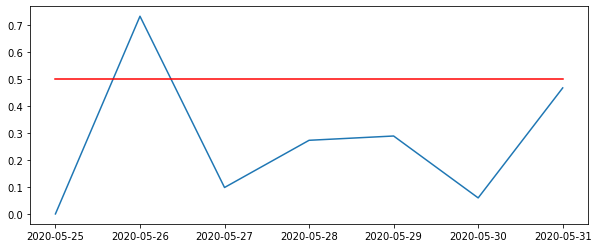

In [ ]:
# построим график изменения p-value по дням
alpha = 0.5
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(sorted(df_mean_conv['date'].unique()), pvalue)
ax.plot(sorted(df_mean_conv['date'].unique()), [alpha]*7, color='red')

Вывод: результаты теста неоднозначны - в тестовой группе есть как значимые изменения относительно контрольной, так и их отсутствие - в зависимости от даты. Необходимо продолжение теста, для установления результата